In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)
import dask.dataframe as dd

from scipy.stats import chi2_contingency, randint
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
df = dd.read_csv(path+'/clustered_hdbscan_df.csv', usecols=['date','agency','agency_name','inquiry_name','brief_description','call_resolution','inquiry_with_description','cluster_label','embed_0','embed_1'])

In [3]:
# Compute the dataframe to see its contents
data_df = df.compute()
data_df['date'] = pd.DatetimeIndex(data_df['date'])

In [4]:
data_df.columns

Index(['date', 'agency', 'agency_name', 'inquiry_name', 'brief_description',
       'call_resolution', 'inquiry_with_description', 'cluster_label',
       'embed_0', 'embed_1'],
      dtype='object')

In [5]:
clusters_df = pd.DataFrame(data_df.groupby(['cluster_label']).count()[['inquiry_name']]).sort_values(by = 'inquiry_name',ascending=False)
clusters_df

,inquiry_name
cluster_label,
-1,1320074
17,717143
25,675138
114,637271
144,575759
...,...
98,576
41,561
180,405


In [6]:
clusters_df[:1]

,inquiry_name
cluster_label,
-1,1320074


In [7]:
clusters_df[1:7].index

Int64Index([17, 25, 114, 144, 150, 13], dtype='int64', name='cluster_label')

### Top 6 clusters according to count
5	Waterway Complaint	3357428
7	Living Wage Increase for Subsidized Projects	2359171
4	Reclaim a Towed Vehicle - NYPD	2320110
11	Smokeless Tobacco Law Information	1670471
3	Carpool or RideMatch	1645582
12	Find a Towed Vehicle - Blocking a Driveway	1243519
13	Pay a Parking Ticket - By Mail	1145085
0	Gas Service and Billing	1085403

In [113]:
all_clusters_data = data_df[data_df['cluster_label'].isin(clusters_df[1:7].index)]

In [9]:
all_clusters_data.cluster_label.unique()

array([114, 144,  25, 150,  13,  17], dtype=int64)

In [114]:
# create a date range from the minimum to maximum date in your data
date_range = pd.date_range(start=all_clusters_data['date'].min(), end=all_clusters_data['date'].max(), freq='D')

# create a DataFrame with the date range
dates_df = pd.DataFrame({'date': date_range})

# merge the two DataFrames using a left join to preserve all dates
daily_clusters_df = pd.merge(dates_df, all_clusters_data.groupby(['date']).size().reset_index(name='inquiries_per_day'), on='date', how='left')

# replace missing values with 0
daily_clusters_df['inquiries_per_day'] = daily_clusters_df['inquiries_per_day'].fillna(0)

In [115]:
top6clusters = {}
daily_clusters = {}
for i,label in enumerate(clusters_df[1:7].index):
    print('Top:',i+1)
    value = data_df[data_df['cluster_label']==label]
    key = f"_{i+1}_{label}"
    top6clusters[key] = value
    value = value.groupby(["date"]).size().reset_index(name="inquiries_per_day")
    daily_clusters[key] = pd.merge(dates_df, value, on='date', how='left')

Top: 1
Top: 2
Top: 3
Top: 4
Top: 5
Top: 6


In [116]:
daily_clusters_df.shape

(1095, 2)

In [117]:
daily_clusters_df = all_clusters_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")

In [14]:
daily_clusters.keys()

dict_keys(['_1_17', '_2_25', '_3_114', '_4_144', '_5_150', '_6_13'])

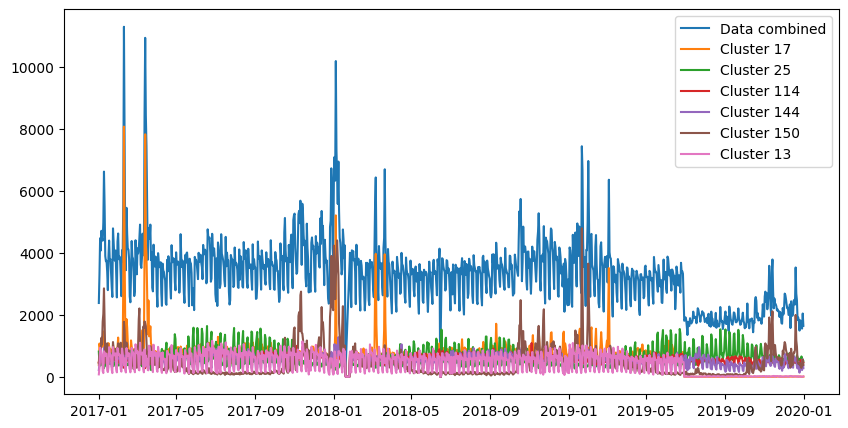

In [110]:
plt.plot(daily_clusters_df['inquiries_per_day'], label='Data combined')
plt.plot(daily_clusters['_1_17']['inquiries_per_day'], label='Cluster 17')
plt.plot(daily_clusters['_2_25']['inquiries_per_day'], label='Cluster 25')
plt.plot(daily_clusters['_3_114']['inquiries_per_day'], label='Cluster 114')
plt.plot(daily_clusters['_4_144']['inquiries_per_day'], label='Cluster 144')
plt.plot(daily_clusters['_5_150']['inquiries_per_day'], label='Cluster 150')
plt.plot(daily_clusters['_6_13']['inquiries_per_day'], label='Cluster 13')
plt.legend();

## Feature Engineering

In [16]:
import holidays
nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019])

In [17]:
# function to create seasons for dataframe
def get_seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

# function to create holidays for dataframe
def get_holidays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''

    # Create a DataFrame of holidays
    holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holidays_df = holidays_df.set_index(['date'])
    
    # Join the holidays DataFrame with the original DataFrame
    df = df.join(holidays_df, on='date')
    df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)

    return df

# function to create weekdays for dataframe
def get_weekdays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''
    df['weekday'] = df.index.weekday
    ### one hot encode the feature weekday
    weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
    df = df.join(weekday_dummies, how='left')

    return df


Sunday - 6
Monday - 0
Tuesday - 1
Wednesday - 2
Thursday - 3
Friday - 4
Saturday - 5

In [18]:
# function to create weekdays for dataframe
def get_features(df,lags):
    '''
    Function to create new features
    Args: df = dataframe, lags = number of lags with high correlation
    Returns: df = dataframe
    '''
    df.reset_index(inplace = True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace = True)

    df = get_seasons(df).fillna(0)
    df = get_holidays(df)
    df = get_weekdays(df)
    if (lags!=0):
        df[f'Inq_mean_{lags}'] = df['inquiries_per_day'].rolling(window=lags).mean()

    return df



# Overall combined dataset of 6 top clusters

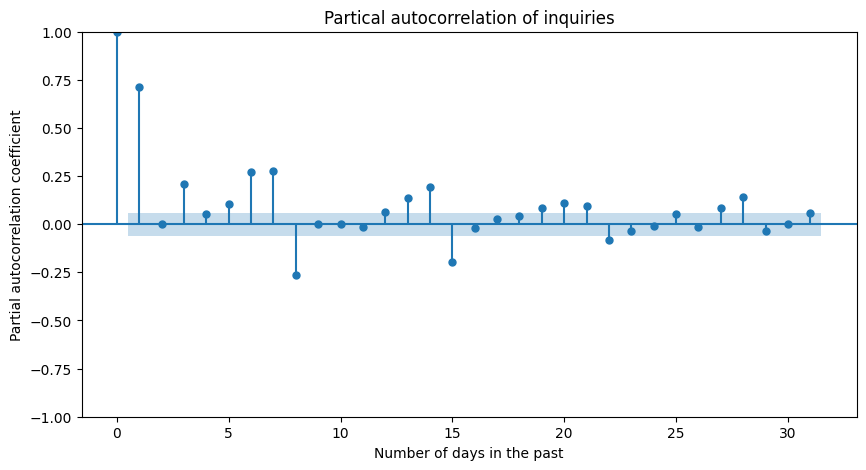

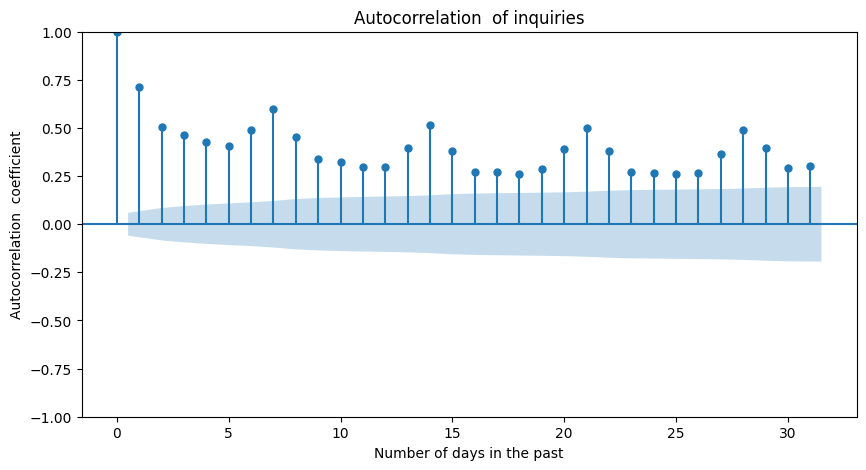

In [19]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [20]:
daily_clusters_df = get_features(daily_clusters_df,1)

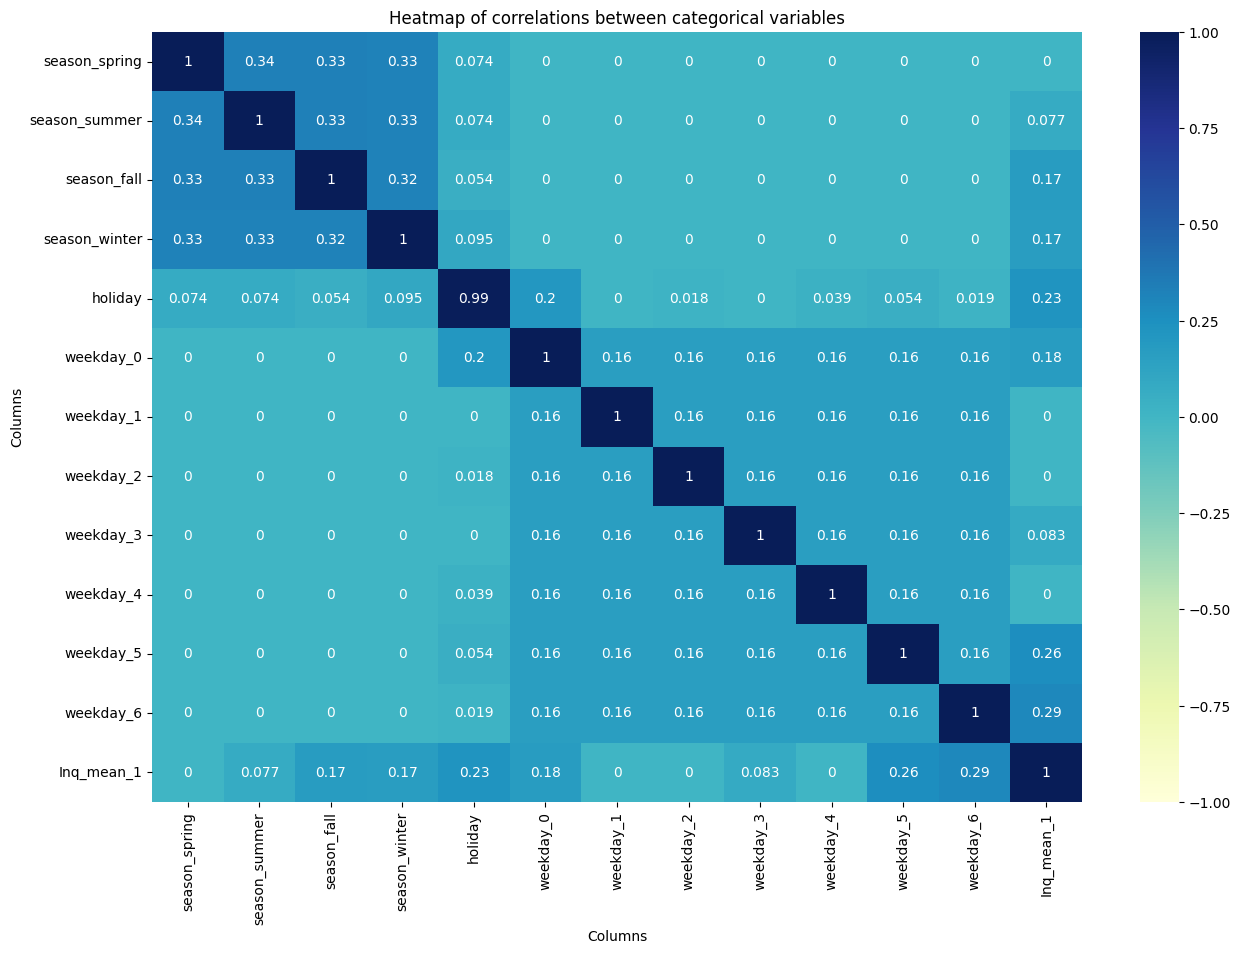

In [21]:
# drop any non-categorical variables
Daily_data_corr_cat = daily_clusters_df.drop(columns=['index','weekday', 'inquiries_per_day'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

### Modeling with Lazy Predict

In [22]:
final_df  = daily_clusters_df.drop(columns=['weekday', 'index']).fillna(0)
final_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_1'],
      dtype='object')

In [23]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:24<00:00,  1.70it/s]

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
LassoLarsCV                                  1.00       1.00    0.00   
RANSACRegressor                              1.00       1.00    0.00   
LarsCV                                       1.00       1.00    0.00   
Lars                                         1.00       1.00    0.00   
OrthogonalMatchingPursuit                    1.00       1.00    0.00   
OrthogonalMatchingPursuitCV                  1.00       1.00    0.00   
HuberRegressor                               1.00       1.00    0.00   
LinearRegression                             1.00       1.00    0.00   
LassoLarsIC                                  1.00       1.00    0.00   
TransformedTargetRegressor                   1.00       1.00    0.00   
PassiveAggressiveRegressor                   1.00       1.00    0.04   
SGDRegressor                                 1.00       1.00    

### Hyperparameter Tuning with cross validation

In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

Grid search on combined dataset

In [25]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,5,7,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 1000}

Modeling with best parameters

In [26]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_all = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_all.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
train_pred = best_rfr_all.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_allTopClusters = best_rfr_all.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, test_pred_allTopClusters)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_all = mean_squared_error(y_test, test_pred_allTopClusters)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_allTopClusters))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = test_pred_allTopClusters.var()
bias = mse_all - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Train MAE:  4.163218390804598
Train RMSE: 27.489475520057056
Test MAE:  113.35321100917432
Test RMSE: 174.23140523111022
Model: Random Forest Regressor
Variance: 265783.13988721493
Bias: -235426.55731840758


Data is still overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [27]:
train_rf = pd.DataFrame()
train_rf['train'] = y_train
train_rf['train_pred'] = train_pred
predictions_rf = pd.DataFrame()
predictions_rf['test'] = y_test
predictions_rf['test_pred'] = test_pred_allTopClusters
train_rf['residuals'] = train_rf['train'] - train_rf['train_pred']
predictions_rf['residuals'] = predictions_rf['test'] - predictions_rf['test_pred']

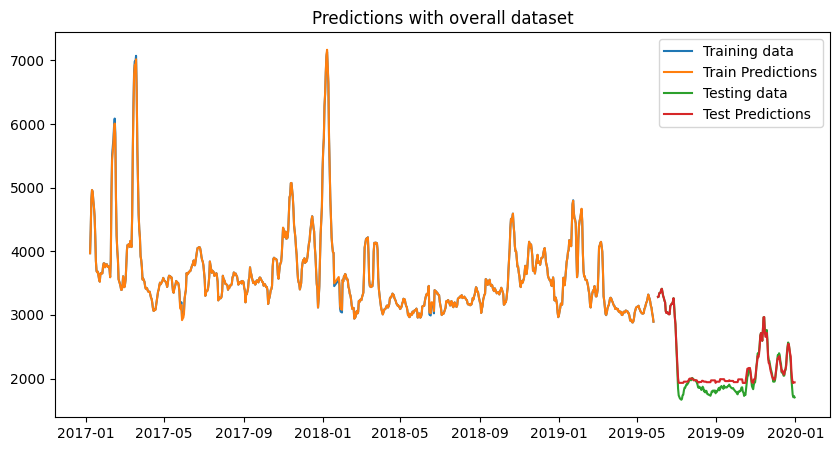

In [28]:
#lag=1
plt.title('Predictions with overall dataset')
plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf[['train_pred']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [29]:
new_plot=train_rf[train_rf.index.year == 2019]

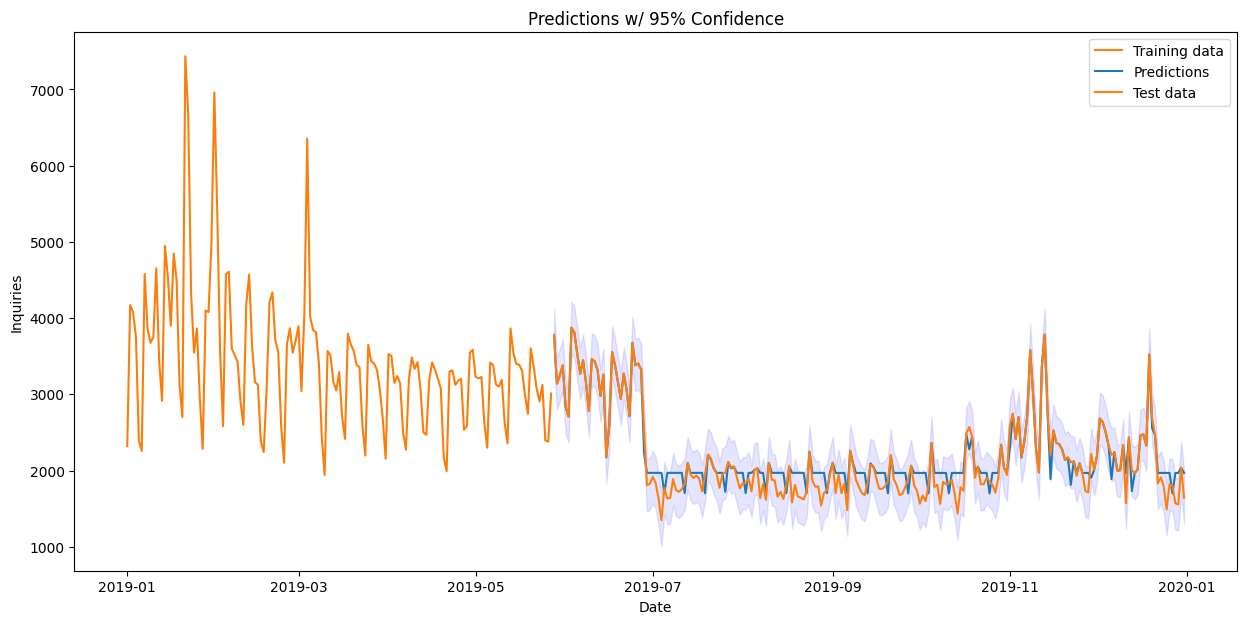

In [30]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf['residuals'] ]) / len(predictions_rf['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['train'], color='#fc7d0b', label='Training data')
ax.plot(predictions_rf.index, predictions_rf['test_pred'], label='Predictions')
ax.plot(predictions_rf.index, predictions_rf['test'], label='Test data')
ax.fill_between(predictions_rf.index, (predictions_rf['test']-band_size), (predictions_rf['test']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

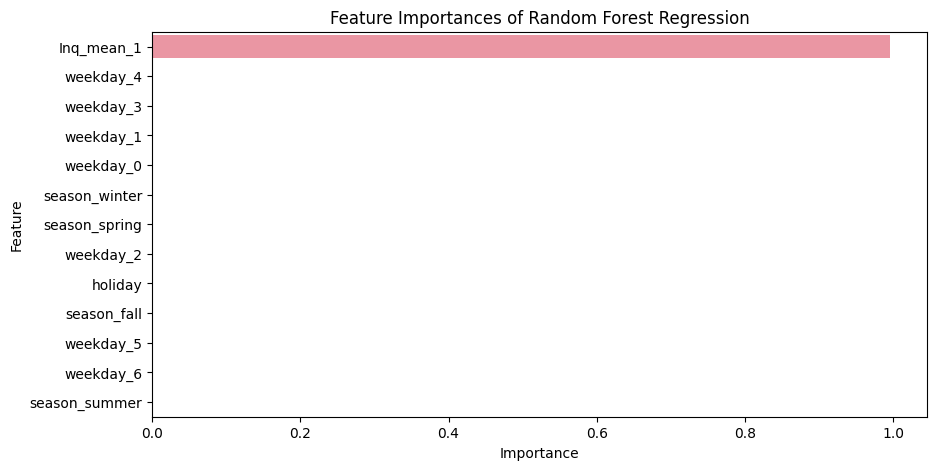

In [31]:
# Access the feature importances
importances = best_rfr_all.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [32]:
predictions_rf

,test,test_pred,residuals
date,,,
2019-05-28,3781,3779,2
2019-05-29,3142,3141,1
2019-05-30,3252,3248,4
2019-05-31,3381,3381,0
2019-06-01,2836,2831,5
...,...,...,...
2019-12-27,1801,1699,102
2019-12-28,1571,1969,-398
2019-12-29,1555,1969,-414


# 1st Top cluster --> cluster_label = 17

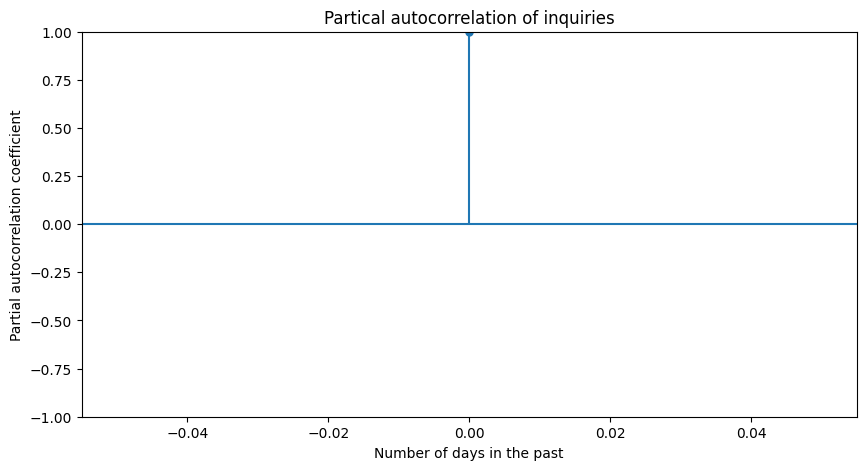

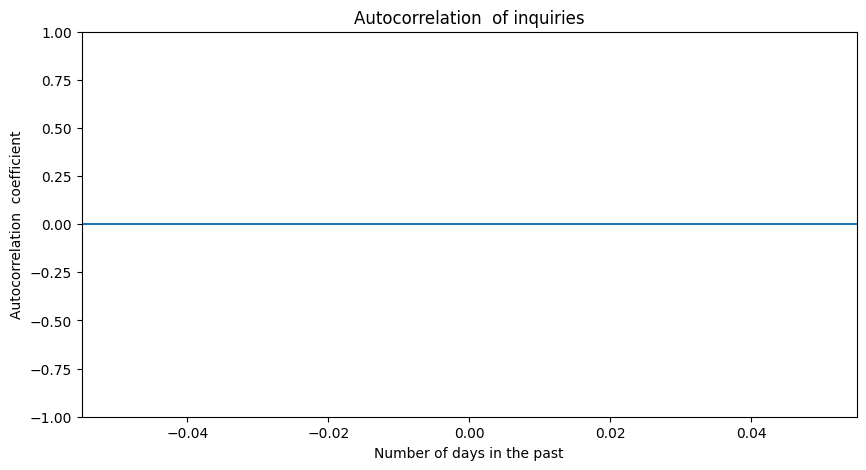

In [118]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_1_17']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_1_17']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [34]:
daily_clusters['_1_17'] = get_features(daily_clusters['_1_17'],0)

### Modeling with Lazy Predict

In [35]:
final_1_df  = daily_clusters['_1_17'].drop(columns=['weekday', 'index']).fillna(0)
final_1_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [36]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_1_df['inquiries_per_day']
X = final_1_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:29<00:00,  1.45it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
PoissonRegressor                             0.04       0.09 662.81   
Ridge                                        0.03       0.09 665.21   
Lars                                         0.03       0.09 665.21   
LassoLarsIC                                  0.03       0.09 665.21   
RidgeCV                                      0.03       0.09 665.21   
BayesianRidge                                0.03       0.09 665.34   
Lasso                                        0.03       0.09 665.40   
ElasticNetCV                                 0.03       0.09 665.51   
SGDRegressor                                 0.03       0.09 665.75   
LassoCV                                      0.03       0.09 666.11   
LassoLarsCV                                  0.03       0.08 666.47   
LarsCV                                       0.03       0.08 666.47   
Transf

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [37]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_1_df['inquiries_per_day']
X = final_1_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


Modeling with best parameters

In [38]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster1 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster1.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_1 = best_rfr_cluster1.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_1 = mean_absolute_error(y_train, train_pred_1)
train_rmse_1 = np.sqrt(mean_squared_error(y_train, train_pred_1))
print("Train MAE of Cluster #1: ", train_mae_1)
print('Train RMSE of Cluster #1:', train_rmse_1)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_1 = best_rfr_cluster1.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_1 = mean_absolute_error(y_test, test_pred_1)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_1 = mean_squared_error(y_test, test_pred_1)
test_rmse_1 = np.sqrt(mean_squared_error(y_test, test_pred_1))
print("Test MAE of Cluster #1: ", test_mae_1)
print('Test RMSE of Cluster #1:', test_rmse_1)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_1 = test_pred_1.var()
bias_1 = mse_1 - variance_1
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #1: {variance_1}')
print(f'Bias of Cluster #1: {bias_1}')

Train MAE of Cluster #1:  203.29794520547946
Train RMSE of Cluster #1: 516.0712790579352
Test MAE of Cluster #1:  659.5981735159818
Test RMSE of Cluster #1: 724.5198945685141
Model: Random Forest Regressor
Variance of Cluster #1: 40934.92879631367
Bias of Cluster #1: 483994.1488292572


In [39]:
train_rf_1 = pd.DataFrame()
train_rf_1['actual_data'] = y_train
train_rf_1['predictions'] = train_pred_1
test_rf_1 = pd.DataFrame()
test_rf_1['actual_data'] = y_test
test_rf_1['predictions'] = test_pred_1
train_rf_1['residuals'] = train_rf_1['actual_data'] - train_rf_1['predictions']
test_rf_1['residuals'] = test_rf_1['actual_data'] - test_rf_1['predictions']

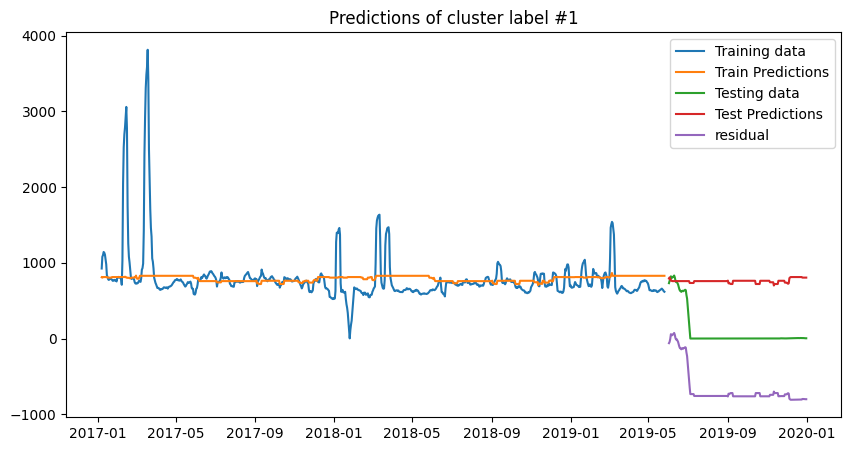

In [40]:
# lag = 1
plt.title('Predictions of cluster label #1')
plt.plot(train_rf_1[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_1[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_1[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_1['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [41]:
new_plot=train_rf_1[train_rf_1.index.year == 2019]

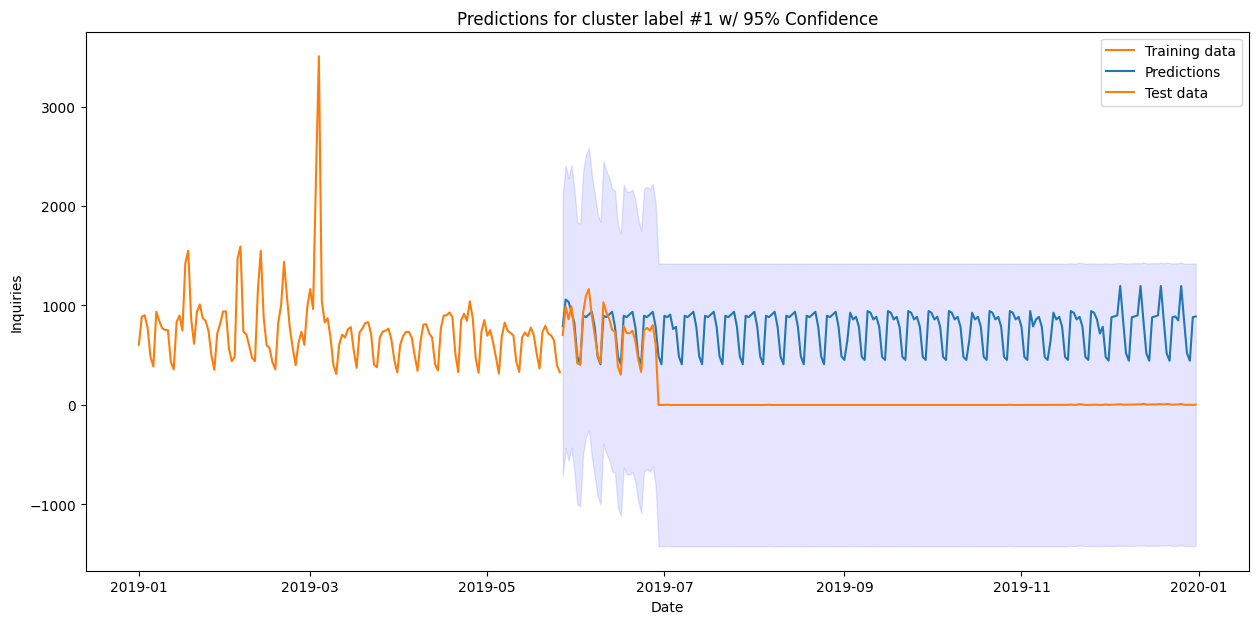

In [42]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_1['residuals'] ]) / len(test_rf_1['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_1.index, test_rf_1['predictions'], label='Predictions')
ax.plot(test_rf_1.index, test_rf_1['actual_data'], label='Test data')
ax.fill_between(test_rf_1.index, (test_rf_1['actual_data']-band_size), (test_rf_1['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #1 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

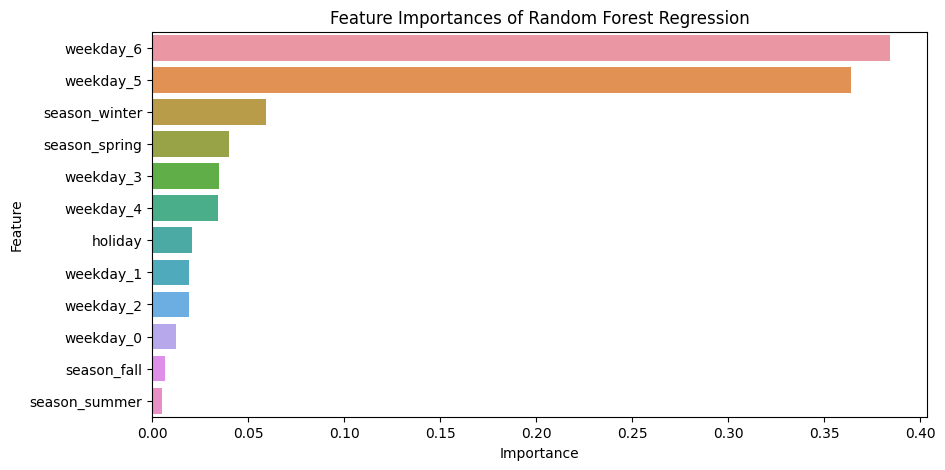

In [43]:
# Access the feature importances
importances = best_rfr_cluster1.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [44]:
test_rf_1

,actual_data,predictions,residuals
date,,,
2019-05-27,703.00,791,-88.00
2019-05-28,991.00,1060,-69.00
2019-05-29,861.00,1037,-176.00
2019-05-30,991.00,937,54.00
2019-05-31,749.00,823,-74.00
...,...,...,...
2019-12-27,2.00,848,-846.00
2019-12-28,1.00,520,-519.00
2019-12-29,2.00,445,-443.00


# 2nd Top cluster --> cluster_label = 25

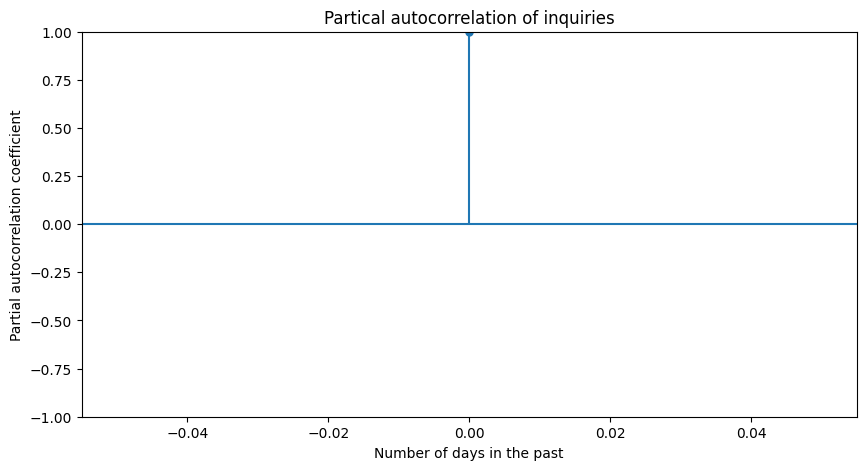

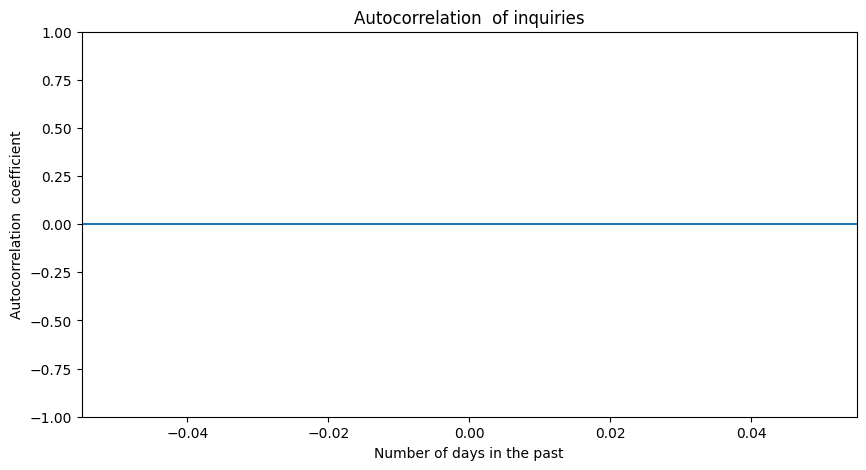

In [119]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_2_25']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_2_25']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [46]:
daily_clusters['_2_25'] = get_features(daily_clusters['_2_25'],0)

### Modeling with Lazy Predict

In [47]:
final_2_df  = daily_clusters['_2_25'].drop(columns=['weekday', 'index']).fillna(0)
final_2_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [48]:
# assigning X and y
y = final_2_df['inquiries_per_day']
X = final_2_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:36<00:00,  1.15it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
DecisionTreeRegressor                        0.64       0.66 154.54   
ExtraTreesRegressor                          0.64       0.66 154.70   
ExtraTreeRegressor                           0.64       0.66 154.94   
LGBMRegressor                                0.63       0.65 156.19   
HistGradientBoostingRegressor                0.63       0.65 156.19   
XGBRegressor                                 0.63       0.65 156.41   
GradientBoostingRegressor                    0.63       0.65 156.61   
RandomForestRegressor                        0.63       0.65 156.73   
BaggingRegressor                             0.62       0.65 157.81   
PoissonRegressor                             0.61       0.63 161.56   
KNeighborsRegressor                          0.59       0.62 163.98   
AdaBoostRegressor                            0.57       0.60 168.43   
HuberR

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [49]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_2_df['inquiries_per_day']
X = final_2_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [50]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster2 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster2.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_2 = best_rfr_cluster2.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_2 = mean_absolute_error(y_train, train_pred_2)
train_rmse_2 = np.sqrt(mean_squared_error(y_train, train_pred_2))
print("Train MAE of Cluster #2: ", train_mae_2)
print('Train RMSE of Cluster #2:', train_rmse_2)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_2 = best_rfr_cluster2.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_2 = mean_absolute_error(y_test, test_pred_2)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_2 = mean_squared_error(y_test, test_pred_2)
test_rmse_2 = np.sqrt(mean_squared_error(y_test, test_pred_2))
print("Test MAE of Cluster #2: ", test_mae_2)
print('Test RMSE of Cluster #2:', test_rmse_2)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_2 = test_pred_2.var()
bias_2 = mse_2 - variance_2
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #2: {variance_2}')
print(f'Bias of Cluster #2: {bias_2}')

Train MAE of Cluster #2:  110.00342465753425
Train RMSE of Cluster #2: 156.0415111319646
Test MAE of Cluster #2:  145.92694063926942
Test RMSE of Cluster #2: 187.84641059281049
Model: Random Forest Regressor
Variance of Cluster #2: 60139.694001376105
Bias of Cluster #2: -24853.420028773362


In [51]:
train_rf_2 = pd.DataFrame()
train_rf_2['actual_data'] = y_train
train_rf_2['predictions'] = train_pred_2
test_rf_2 = pd.DataFrame()
test_rf_2['actual_data'] = y_test
test_rf_2['predictions'] = test_pred_2
train_rf_2['residuals'] = train_rf_2['actual_data'] - train_rf_2['predictions']
test_rf_2['residuals'] = test_rf_2['actual_data'] - test_rf_2['predictions']

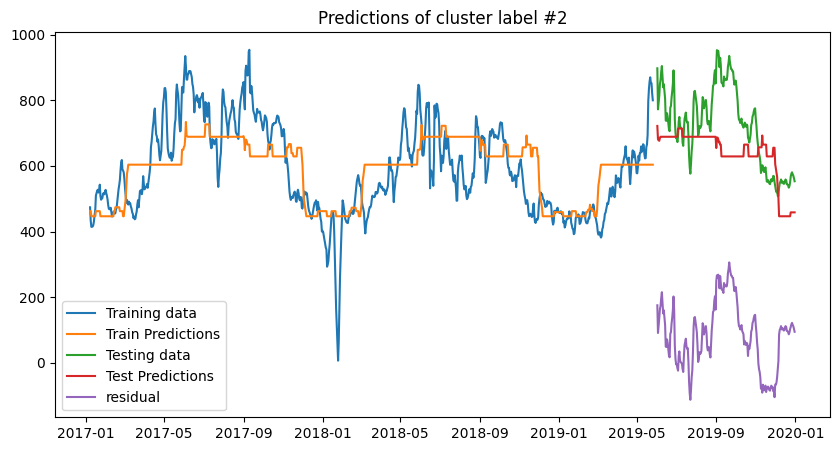

In [52]:
plt.title('Predictions of cluster label #2')
plt.plot(train_rf_2[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_2[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_2[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_2['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [53]:
new_plot=train_rf_2[train_rf_2.index.year == 2019]

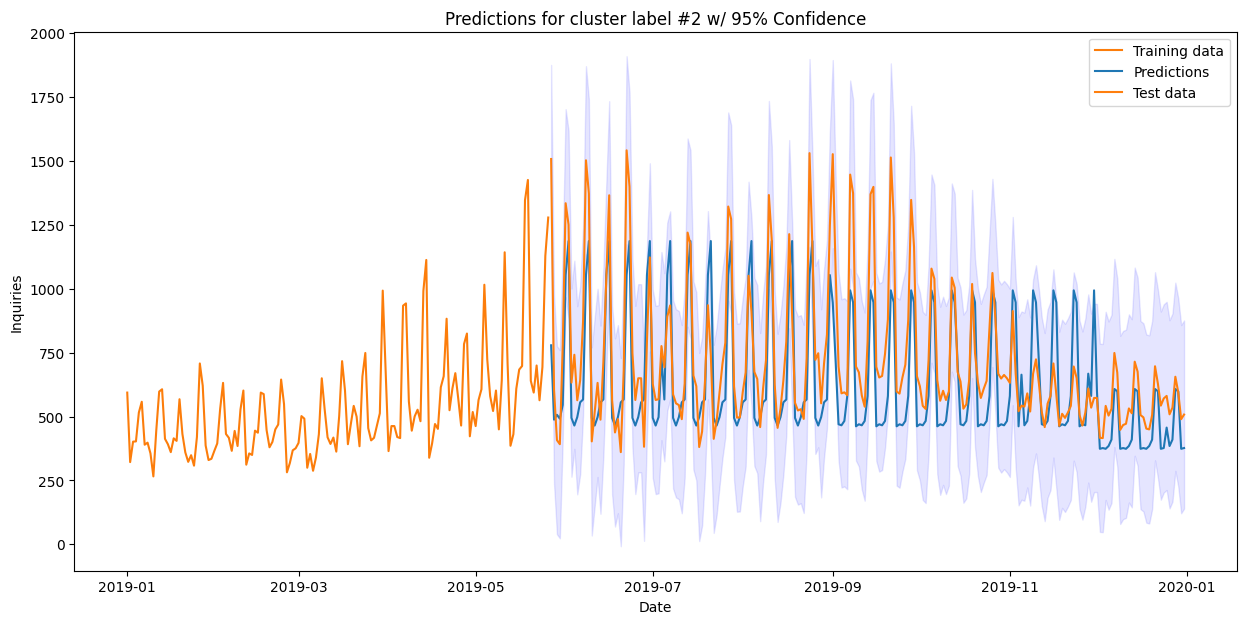

In [54]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_2['residuals'] ]) / len(test_rf_2['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_2.index, test_rf_2['predictions'], label='Predictions')
ax.plot(test_rf_2.index, test_rf_2['actual_data'], label='Test data')
ax.fill_between(test_rf_2.index, (test_rf_2['actual_data']-band_size), (test_rf_2['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #2 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

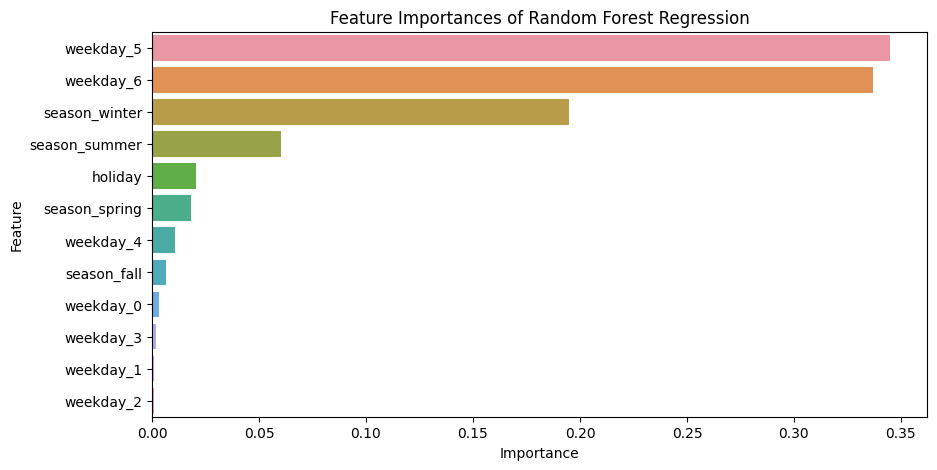

In [55]:
# Access the feature importances
importances = best_rfr_cluster2.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [56]:
test_rf_2

,actual_data,predictions,residuals
date,,,
2019-05-27,1508.00,779,729.00
2019-05-28,606.00,488,118.00
2019-05-29,408.00,507,-99.00
2019-05-30,392.00,492,-100.00
2019-05-31,782.00,546,236.00
...,...,...,...
2019-12-27,535.00,410,125.00
2019-12-28,656.00,608,48.00
2019-12-29,595.00,599,-4.00


In [57]:
train_rf_2

,actual_data,predictions,residuals
date,,,
2017-01-01,812.00,599,213.00
2017-01-02,405.00,483,-78.00
2017-01-03,359.00,377,-18.00
2017-01-04,370.00,374,-4.00
2017-01-05,394.00,385,9.00
...,...,...,...
2019-05-22,700.00,507,193.00
2019-05-23,564.00,492,72.00
2019-05-24,694.00,546,148.00


# 3rd Top cluster --> cluster_label = 114

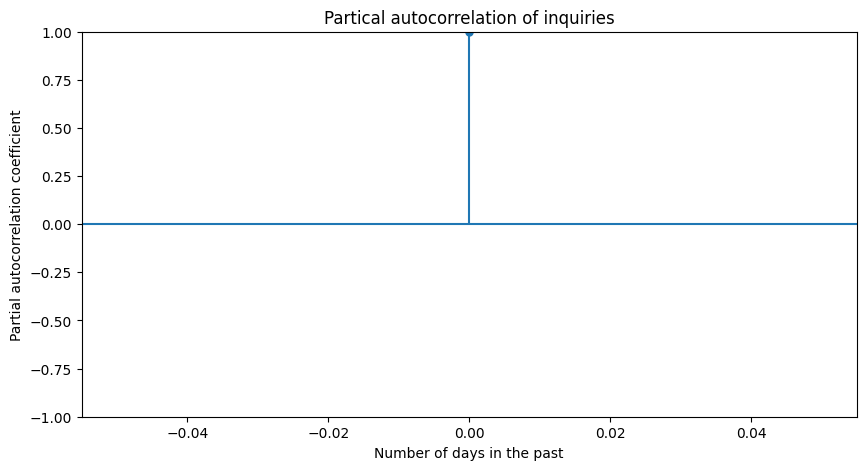

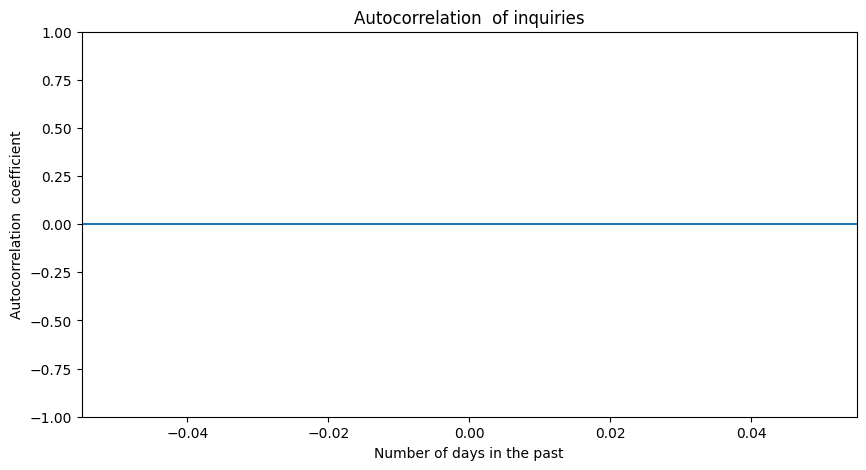

In [58]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_3_114']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_3_114']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [59]:
daily_clusters['_3_114'] = get_features(daily_clusters['_3_114'],0)

### Modeling with Lazy Predict

In [60]:
final_3_df  = daily_clusters['_3_114'].drop(columns=['weekday', 'index']).fillna(0)
final_3_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [61]:
# assigning X and y
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:35<00:00,  1.18it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ElasticNetCV                                 0.22       0.26  98.77   
Lasso                                        0.22       0.26  98.79   
SGDRegressor                                 0.21       0.26  98.84   
BayesianRidge                                0.21       0.26  98.85   
LassoCV                                      0.21       0.26  98.86   
RidgeCV                                      0.21       0.26  98.91   
Ridge                                        0.21       0.26  98.96   
LassoLarsCV                                  0.21       0.26  98.96   
Lars                                         0.21       0.26  98.96   
LarsCV                                       0.21       0.26  98.96   
LassoLarsIC                                  0.21       0.26  98.96   
OrthogonalMatchingPursuitCV                  0.21       0.25  99.04   
Poisso

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [62]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


Modeling with best parameters

In [63]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster3 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster3.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_3 = best_rfr_cluster3.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_3 = mean_absolute_error(y_train, train_pred_3)
train_rmse_3 = np.sqrt(mean_squared_error(y_train, train_pred_3))
print("Train MAE of Cluster #3: ", train_mae_3)
print('Train RMSE of Cluster #3:', train_rmse_3)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_3 = best_rfr_cluster3.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_3 = mean_absolute_error(y_test, test_pred_3)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_3 = mean_squared_error(y_test, test_pred_3)
test_rmse_3 = np.sqrt(mean_squared_error(y_test, test_pred_3))
print("Test MAE of Cluster #3: ", test_mae_3)
print('Test RMSE of Cluster #3:', test_rmse_3)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_3 = test_pred_3.var()
bias_3 = mse_3 - variance_3
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #3: {variance_3}')
print(f'Bias of Cluster #3: {bias_3}')

Train MAE of Cluster #3:  59.81164383561644
Train RMSE of Cluster #3: 90.96487480059864
Test MAE of Cluster #3:  134.5662100456621
Test RMSE of Cluster #3: 151.2841229103334
Model: Random Forest Regressor
Variance of Cluster #3: 7513.81747669982
Bias of Cluster #3: 15373.06836804904


In [64]:
train_rf_3 = pd.DataFrame()
train_rf_3['actual_data'] = y_train
train_rf_3['predictions'] = train_pred_3
test_rf_3 = pd.DataFrame()
test_rf_3['actual_data'] = y_test
test_rf_3['predictions'] = test_pred_3
train_rf_3['residuals'] = train_rf_3['actual_data'] - train_rf_3['predictions']
test_rf_3['residuals'] = test_rf_3['actual_data'] - test_rf_3['predictions']

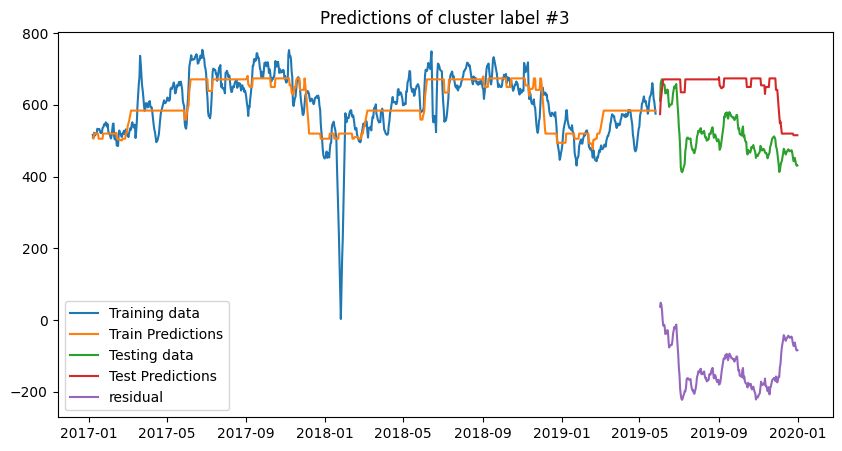

In [65]:
plt.title('Predictions of cluster label #3')
plt.plot(train_rf_3[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_3[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_3[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_3['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [66]:
new_plot=train_rf_3[train_rf_3.index.year == 2019]

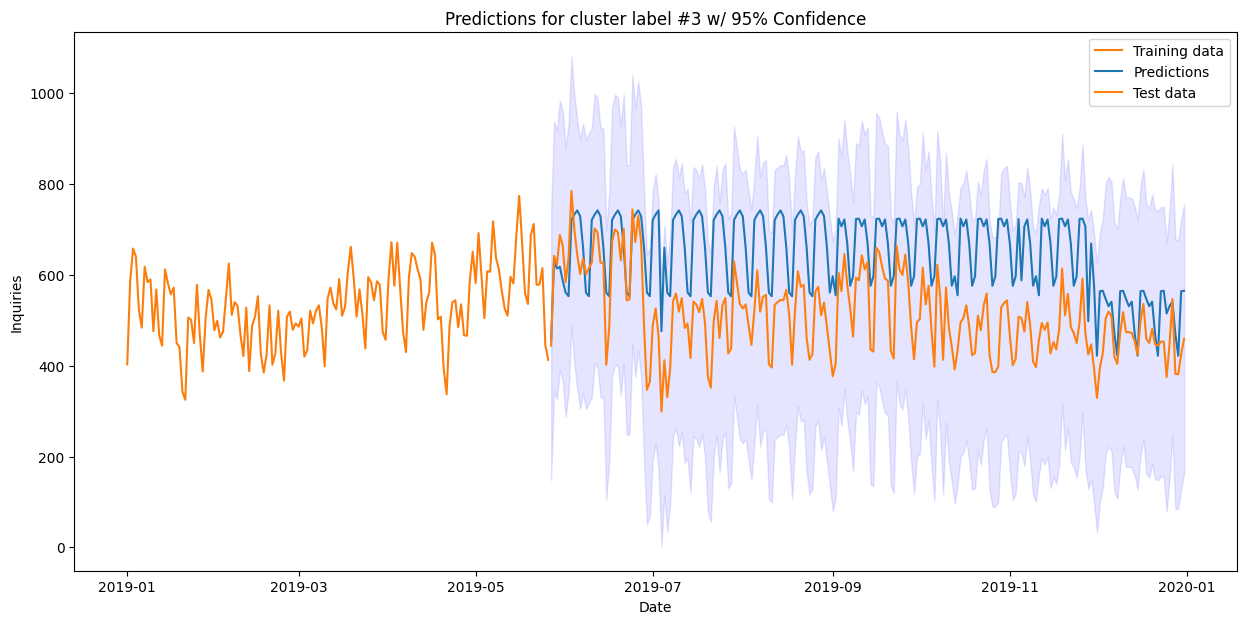

In [67]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_3['residuals'] ]) / len(test_rf_3['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_3.index, test_rf_3['predictions'], label='Predictions')
ax.plot(test_rf_3.index, test_rf_3['actual_data'], label='Test data')
ax.fill_between(test_rf_3.index, (test_rf_3['actual_data']-band_size), (test_rf_3['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #3 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

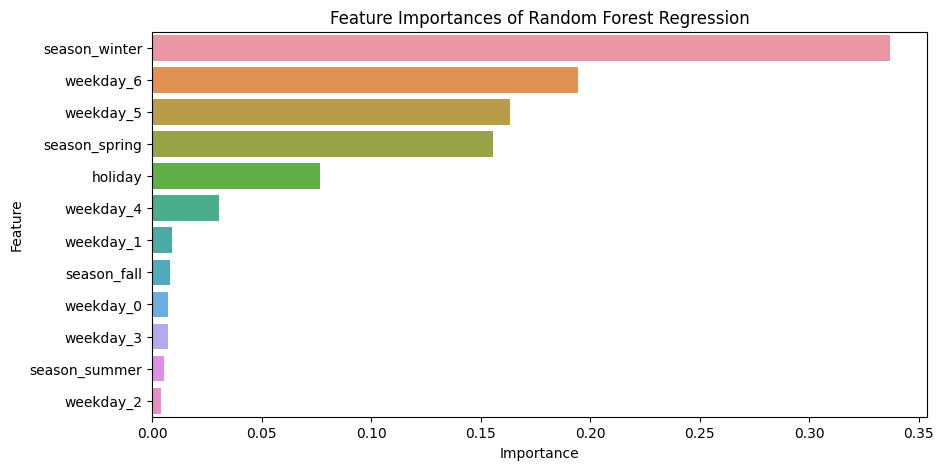

In [68]:
# Access the feature importances
importances = best_rfr_cluster3.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [69]:
test_rf_3

,actual_data,predictions,residuals
date,,,
2019-05-27,444.00,456,-12.00
2019-05-28,642.00,631,11.00
2019-05-29,622.00,614,8.00
2019-05-30,688.00,618,70.00
2019-05-31,664.00,587,77.00
...,...,...,...
2019-12-27,547.00,541,6.00
2019-12-28,382.00,470,-88.00
2019-12-29,381.00,422,-41.00


# 4th Top cluster --> cluster_label = 144

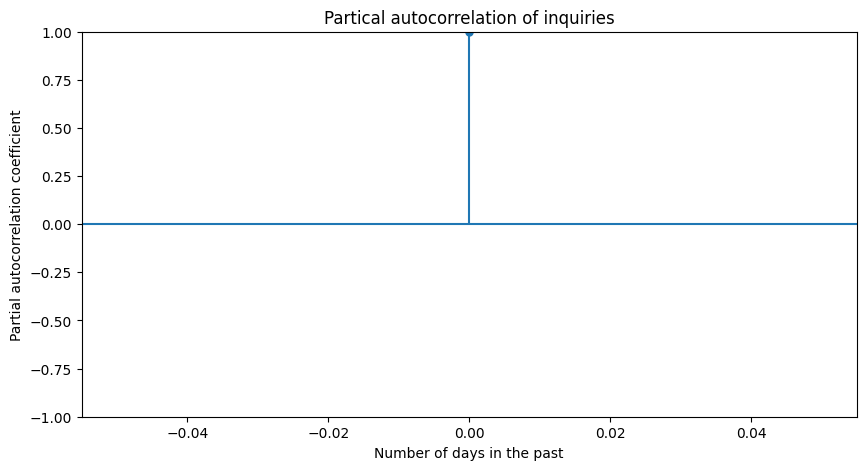

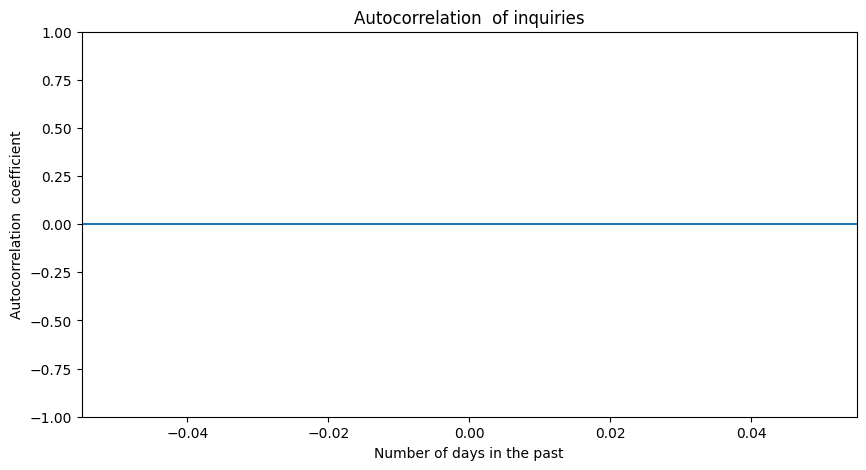

In [70]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_4_144']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_4_144']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [71]:
daily_clusters['_4_144'] = get_features(daily_clusters['_4_144'],0)

### Modeling with Lazy Predict

In [72]:
final_4_df  = daily_clusters['_4_144'].drop(columns=['weekday', 'index']).fillna(0)
final_4_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [73]:
# assigning X and y
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:46<00:00,  1.10s/it]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GradientBoostingRegressor                    0.56       0.58 115.59   
PoissonRegressor                             0.55       0.58 116.21   
LGBMRegressor                                0.55       0.58 116.28   
HistGradientBoostingRegressor                0.55       0.58 116.28   
XGBRegressor                                 0.55       0.58 116.36   
ElasticNetCV                                 0.55       0.58 116.56   
SGDRegressor                                 0.55       0.57 116.82   
RidgeCV                                      0.55       0.57 116.83   
BayesianRidge                                0.55       0.57 116.86   
TransformedTargetRegressor                   0.55       0.57 116.86   
LinearRegression                             0.55       0.57 116.86   
Lasso                                        0.55       0.57 116.94   
Ridge 

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [74]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


Modeling with best parameters

In [75]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster4 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster4.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_4 = best_rfr_cluster4.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_4 = mean_absolute_error(y_train, train_pred_4)
train_rmse_4 = np.sqrt(mean_squared_error(y_train, train_pred_4))
print("Train MAE of Cluster #4: ", train_mae_4)
print('Train RMSE of Cluster #4:', train_rmse_4)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_4 = best_rfr_cluster4.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_4 = mean_absolute_error(y_test, test_pred_4)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_4 = mean_squared_error(y_test, test_pred_4)
test_rmse_4 = np.sqrt(mean_squared_error(y_test, test_pred_4))
print("Test MAE of Cluster #4: ", test_mae_4)
print('Test RMSE of Cluster #4:', test_rmse_4)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_4 = test_pred_4.var()
bias_4 = mse_4 - variance_4
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #4: {variance_4}')
print(f'Bias of Cluster #4: {bias_4}')

Train MAE of Cluster #4:  68.91324200913242
Train RMSE of Cluster #4: 103.98142616016271
Test MAE of Cluster #4:  163.01826484018264
Test RMSE of Cluster #4: 198.9824457047157
Model: Random Forest Regressor
Variance of Cluster #4: 32177.857259022956
Bias of Cluster #4: 7416.156439607181


In [76]:
train_rf_4 = pd.DataFrame()
train_rf_4['actual_data'] = y_train
train_rf_4['predictions'] = train_pred_4
test_rf_4 = pd.DataFrame()
test_rf_4['actual_data'] = y_test
test_rf_4['predictions'] = test_pred_4
train_rf_4['residuals'] = train_rf_4['actual_data'] - train_rf_4['predictions']
test_rf_4['residuals'] = test_rf_4['actual_data'] - test_rf_4['predictions']

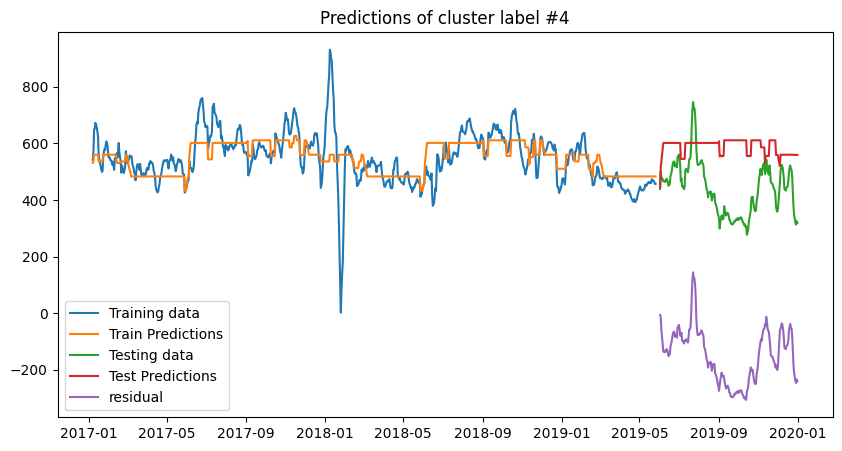

In [77]:
# lag=1
plt.title('Predictions of cluster label #4')
plt.plot(train_rf_4[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_4[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_4[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_4['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [78]:
new_plot=train_rf_4[train_rf_4.index.year == 2019]

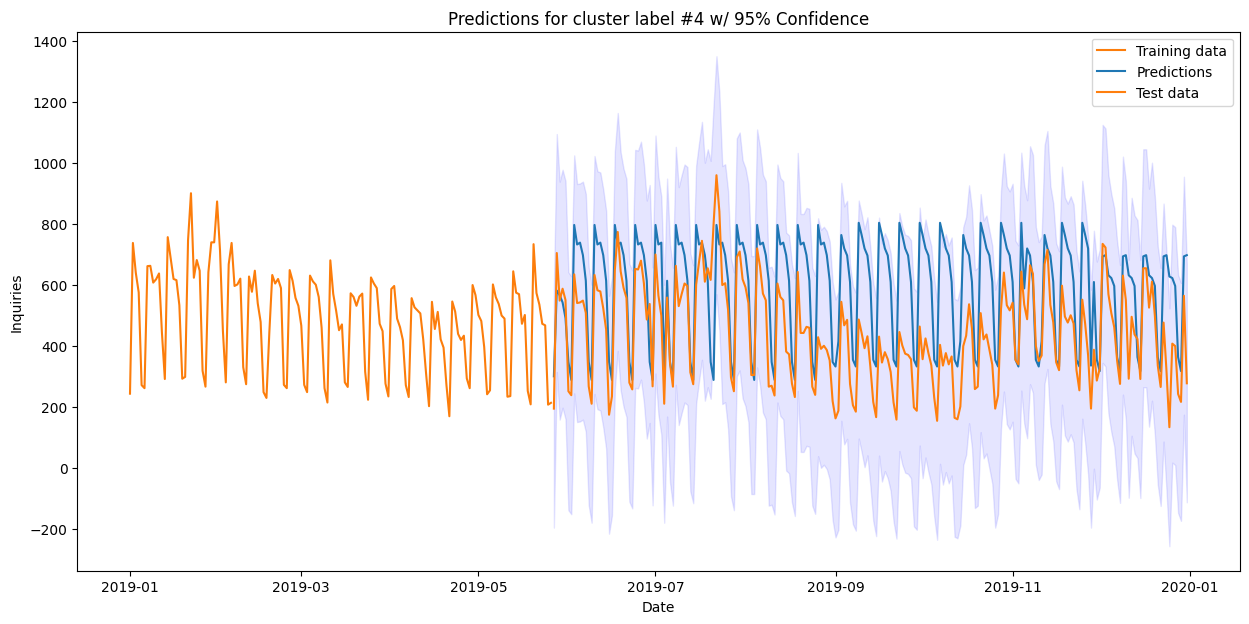

In [79]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_4['residuals'] ]) / len(test_rf_4['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_4.index, test_rf_4['predictions'], label='Predictions')
ax.plot(test_rf_4.index, test_rf_4['actual_data'], label='Test data')
ax.fill_between(test_rf_4.index, (test_rf_4['actual_data']-band_size), (test_rf_4['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #4 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

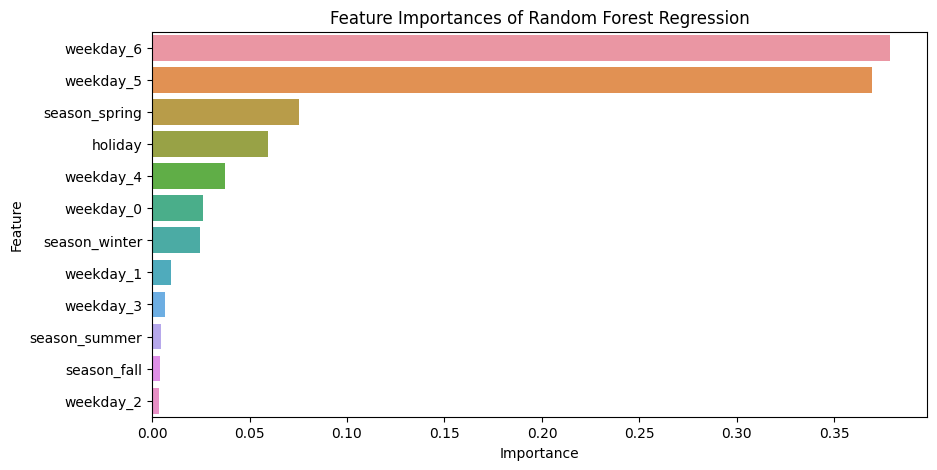

In [80]:
# Access the feature importances
importances = best_rfr_cluster4.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [81]:
test_rf_4

,actual_data,predictions,residuals
date,,,
2019-05-27,194.00,300,-106.00
2019-05-28,704.00,581,123.00
2019-05-29,548.00,566,-18.00
2019-05-30,587.00,542,45.00
2019-05-31,550.00,491,59.00
...,...,...,...
2019-12-27,399.00,596,-197.00
2019-12-28,242.00,363,-121.00
2019-12-29,216.00,317,-101.00


# 5th Top cluster --> cluster_label = 150

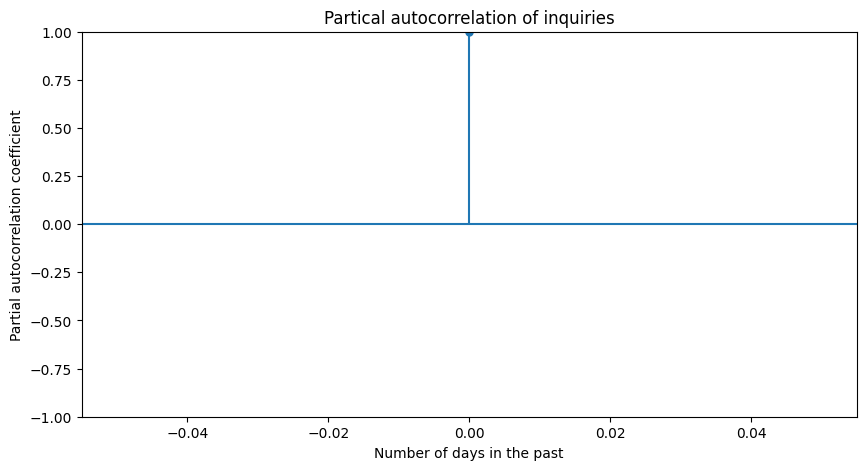

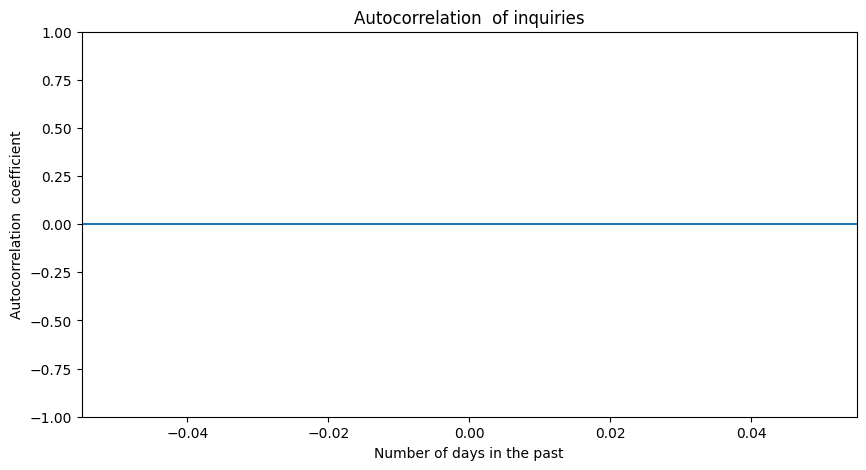

In [82]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_5_150']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_5_150']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [83]:
daily_clusters['_5_150'] = get_features(daily_clusters['_5_150'],0)

### Modeling with Lazy Predict

In [84]:
final_5_df  = daily_clusters['_5_150'].drop(columns=['weekday', 'index']).fillna(0)
final_5_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [85]:
# assigning X and y
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:31<00:00,  1.31it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
OrthogonalMatchingPursuitCV                  0.26       0.30 479.29   
LarsCV                                       0.24       0.28 485.28   
LassoLarsCV                                  0.24       0.28 485.28   
LassoLars                                    0.24       0.28 485.35   
LassoCV                                      0.24       0.28 485.38   
LassoLarsIC                                  0.24       0.28 486.75   
SGDRegressor                                 0.23       0.27 488.49   
Lasso                                        0.23       0.27 488.61   
Lars                                         0.23       0.27 488.96   
Ridge                                        0.23       0.27 488.96   
RidgeCV                                      0.23       0.27 489.02   
BayesianRidge                                0.23       0.27 489.29   
Poisso

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [86]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1000}


Modeling with best parameters

In [87]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster5 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster5.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_5 = best_rfr_cluster5.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_5 = mean_absolute_error(y_train, train_pred_5)
train_rmse_5 = np.sqrt(mean_squared_error(y_train, train_pred_5))
print("Train MAE of Cluster #5: ", train_mae_5)
print('Train RMSE of Cluster #5:', train_rmse_5)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_5 = best_rfr_cluster5.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_5 = mean_absolute_error(y_test, test_pred_5)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_5 = mean_squared_error(y_test, test_pred_5)
test_rmse_5 = np.sqrt(mean_squared_error(y_test, test_pred_5))
print("Test MAE of Cluster #5: ", test_mae_5)
print('Test RMSE of Cluster #5:', test_rmse_5)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_5 = test_pred_5.var()
bias_5 = mse_5 - variance_5
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #5: {variance_5}')
print(f'Bias of Cluster #5: {bias_5}')

Train MAE of Cluster #5:  291.6563926940639
Train RMSE of Cluster #5: 501.09091834465386
Test MAE of Cluster #5:  234.8538812785388
Test RMSE of Cluster #5: 345.6146731305039
Model: Random Forest Regressor
Variance of Cluster #5: 85405.17149350513
Bias of Cluster #5: 34044.3307895999


In [88]:
train_rf_5 = pd.DataFrame()
train_rf_5['actual_data'] = y_train
train_rf_5['predictions'] = train_pred_5
test_rf_5 = pd.DataFrame()
test_rf_5['actual_data'] = y_test
test_rf_5['predictions'] = test_pred_5
train_rf_5['residuals'] = train_rf_5['actual_data'] - train_rf_5['predictions']
test_rf_5['residuals'] = test_rf_5['actual_data'] - test_rf_5['predictions']

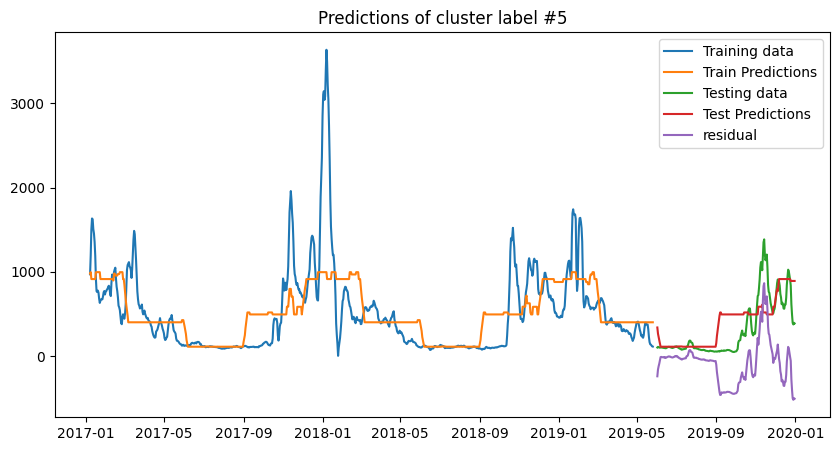

In [89]:
# lag=1
plt.title('Predictions of cluster label #5')
plt.plot(train_rf_5[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_5[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_5[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_5['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [90]:
new_plot=train_rf_5[train_rf_5.index.year == 2019]

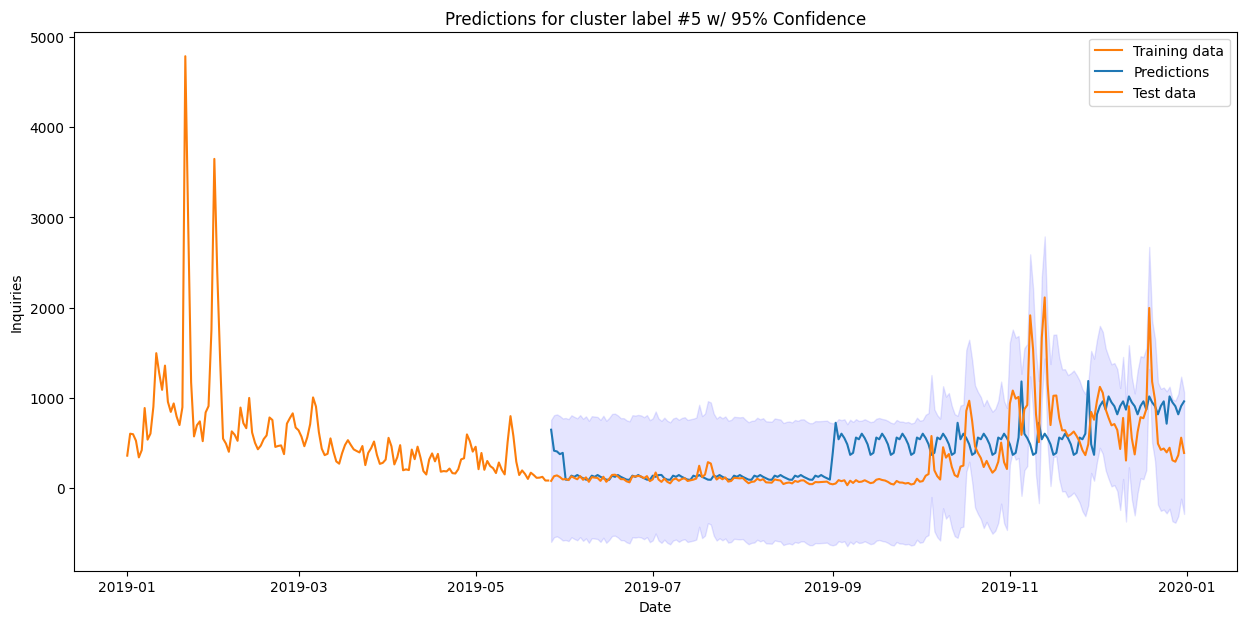

In [91]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_5['residuals'] ]) / len(test_rf_5['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_5.index, test_rf_5['predictions'], label='Predictions')
ax.plot(test_rf_5.index, test_rf_5['actual_data'], label='Test data')
ax.fill_between(test_rf_5.index, (test_rf_5['actual_data']-band_size), (test_rf_5['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #5 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

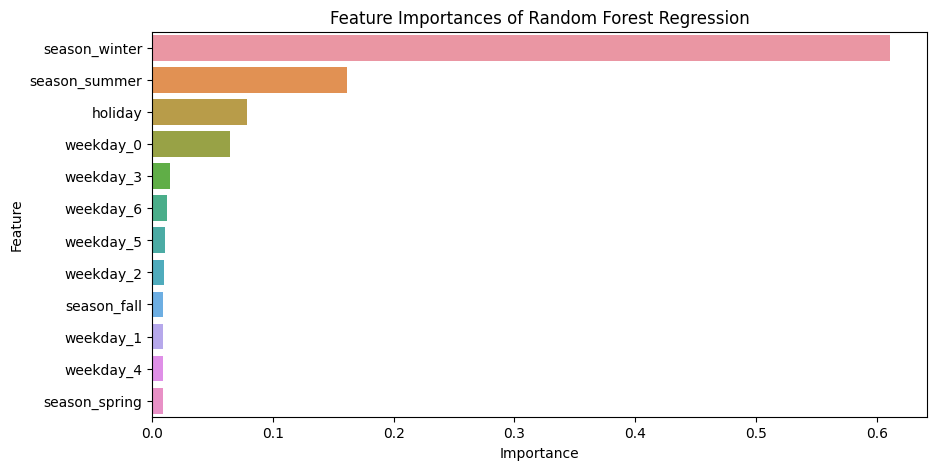

In [92]:
# Access the feature importances
importances = best_rfr_cluster5.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [93]:
test_rf_5

,actual_data,predictions,residuals
date,,,
2019-05-27,75.00,643,-568.00
2019-05-28,127.00,410,-283.00
2019-05-29,136.00,402,-266.00
2019-05-30,118.00,372,-254.00
2019-05-31,91.00,386,-295.00
...,...,...,...
2019-12-27,304.00,947,-643.00
2019-12-28,288.00,904,-616.00
2019-12-29,360.00,814,-454.00


# 6 Top cluster --> cluster_label = 13

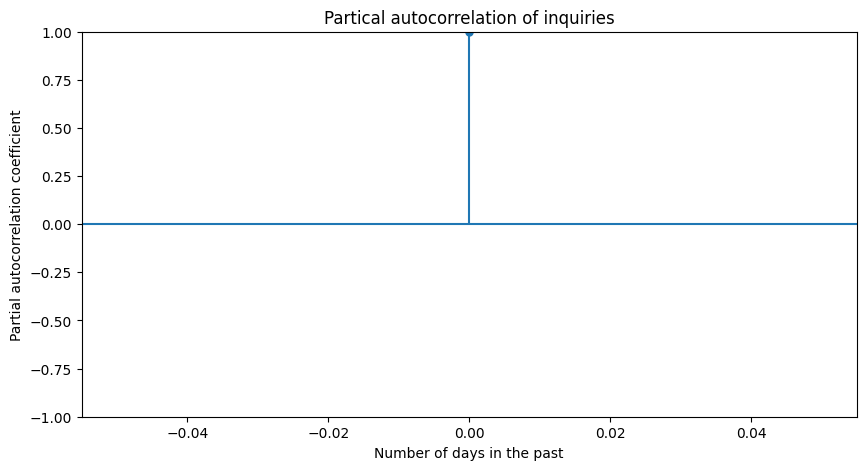

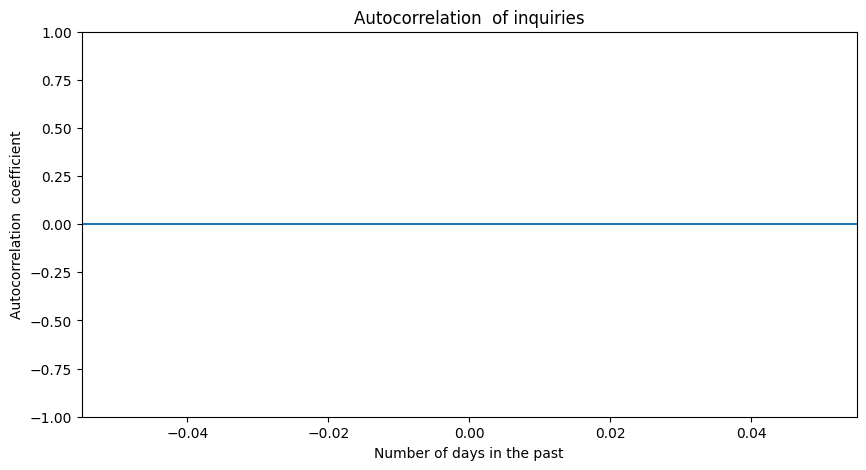

In [94]:
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters['_6_13']['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters['_6_13']['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [95]:
daily_clusters['_6_13'] = get_features(daily_clusters['_6_13'],0)

### Modeling with Lazy Predict

In [96]:
final_6_df  = daily_clusters['_6_13'].drop(columns=['weekday', 'index']).fillna(0)
final_6_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [97]:
# assigning X and y
y = final_6_df['inquiries_per_day']
X = final_6_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
PoissonRegressor                             0.35       0.39 260.83   
TransformedTargetRegressor                   0.34       0.37 264.15   
LinearRegression                             0.34       0.37 264.15   
SGDRegressor                                 0.34       0.37 264.25   
RidgeCV                                      0.34       0.37 264.34   
BayesianRidge                                0.34       0.37 264.34   
Ridge                                        0.34       0.37 264.35   
Lars                                         0.34       0.37 264.35   
Lasso                                        0.33       0.37 264.52   
LGBMRegressor                                0.33       0.37 264.55   
HistGradientBoostingRegressor                0.33       0.37 264.55   
LassoLarsIC                                  0.33       0.37 264.69   
LarsCV

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [98]:
# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_6_df['inquiries_per_day']
X = final_6_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


Modeling with best parameters

In [99]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster6 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster6.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_6 = best_rfr_cluster6.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_6 = mean_absolute_error(y_train, train_pred_6)
train_rmse_6 = np.sqrt(mean_squared_error(y_train, train_pred_6))
print("Train MAE of Cluster #6: ", train_mae_6)
print('Train RMSE of Cluster #6:', train_rmse_6)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_6 = best_rfr_cluster6.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_6 = mean_absolute_error(y_test, test_pred_6)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_6 = mean_squared_error(y_test, test_pred_6)
test_rmse_6 = np.sqrt(mean_squared_error(y_test, test_pred_6))
print("Test MAE of Cluster #6: ", test_mae_6)
print('Test RMSE of Cluster #6:', test_rmse_6)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_6 = test_pred_6.var()
bias_6 = mse_6 - variance_6
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #6: {variance_6}')
print(f'Bias of Cluster #6: {bias_6}')

Train MAE of Cluster #6:  74.74543378995433
Train RMSE of Cluster #6: 115.07769362815826
Test MAE of Cluster #6:  476.9406392694064
Test RMSE of Cluster #6: 553.7802096030024
Model: Random Forest Regressor
Variance of Cluster #6: 68533.63983236381
Bias of Cluster #6: 238138.8807155814


In [100]:
train_rf_6 = pd.DataFrame()
train_rf_6['actual_data'] = y_train
train_rf_6['predictions'] = train_pred_6
test_rf_6 = pd.DataFrame()
test_rf_6['actual_data'] = y_test
test_rf_6['predictions'] = test_pred_6
train_rf_6['residuals'] = train_rf_6['actual_data'] - train_rf_6['predictions']
test_rf_6['residuals'] = test_rf_6['actual_data'] - test_rf_6['predictions']

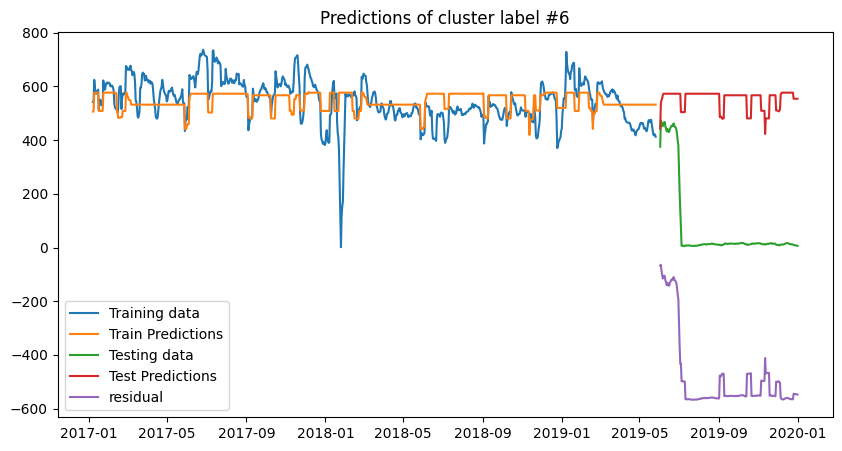

In [101]:
#lag=1
plt.title('Predictions of cluster label #6')
plt.plot(train_rf_6[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_6[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_6[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_6['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [102]:
new_plot=train_rf_6[train_rf_6.index.year == 2019]

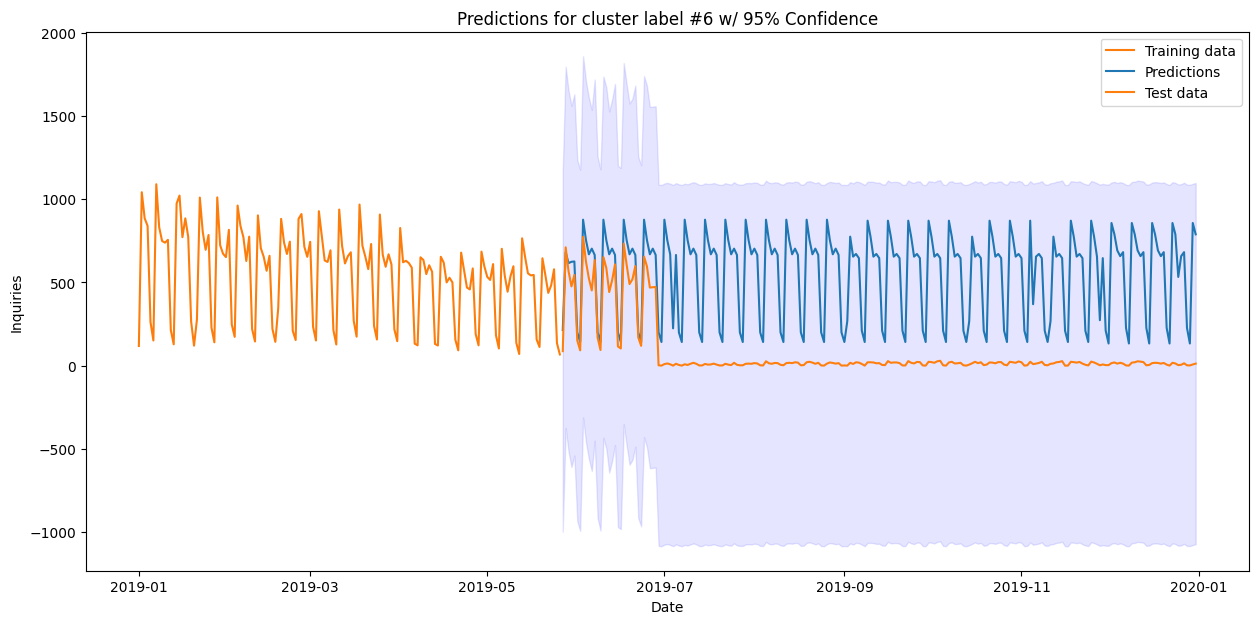

In [103]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_6['residuals'] ]) / len(test_rf_6['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_6.index, test_rf_6['predictions'], label='Predictions')
ax.plot(test_rf_6.index, test_rf_6['actual_data'], label='Test data')
ax.fill_between(test_rf_6.index, (test_rf_6['actual_data']-band_size), (test_rf_6['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #6 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

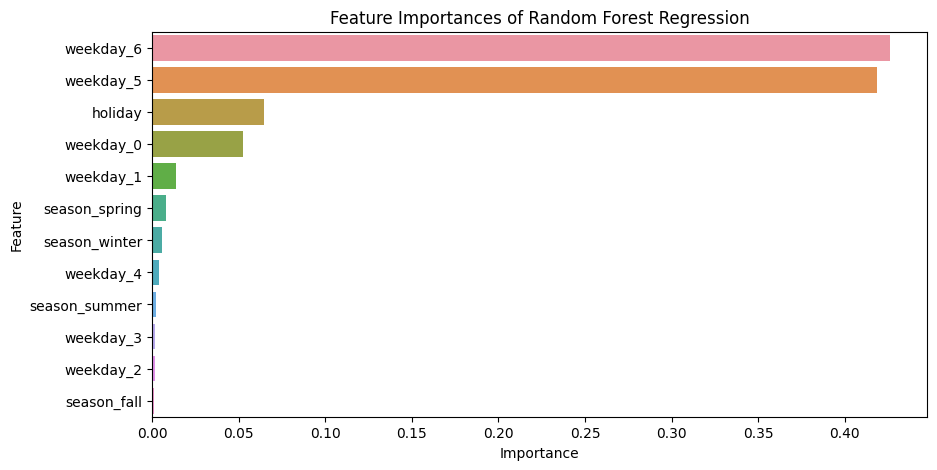

In [104]:
# Access the feature importances
importances = best_rfr_cluster6.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [105]:
test_rf_6

,actual_data,predictions,residuals
date,,,
2019-05-27,87.00,214,-127.00
2019-05-28,711.00,680,31.00
2019-05-29,567.00,616,-49.00
2019-05-30,476.00,624,-148.00
2019-05-31,545.00,626,-81.00
...,...,...,...
2019-12-27,14.00,682,-668.00
2019-12-28,2.00,227,-225.00
2019-12-29,1.00,133,-132.00


# Combining predictions

In [106]:
test_combined_clusters = pd.DataFrame()
test_combined_clusters['predictions'] = test_rf_1['predictions']+ test_rf_2['predictions']+test_rf_3['predictions']+test_rf_4['predictions']+test_rf_5['predictions']+test_rf_6['predictions']

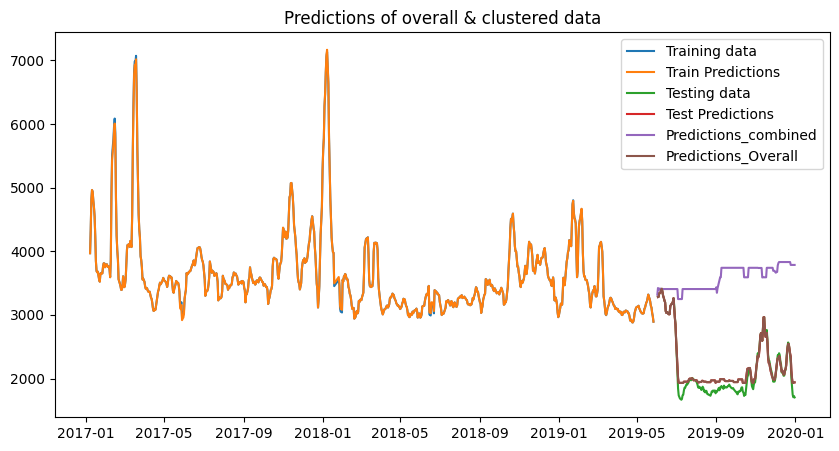

In [107]:
plt.title('Predictions of overall & clustered data')

plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf[['train_pred']].sort_index().rolling(7).mean(), label='Train Predictions')

plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_combined_clusters['predictions'].fillna(0).sort_index().rolling(7).mean(),label='Predictions_combined')
plt.plot(predictions_rf['test_pred'].fillna(0).sort_index().rolling(7).mean(),label='Predictions_Overall')
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

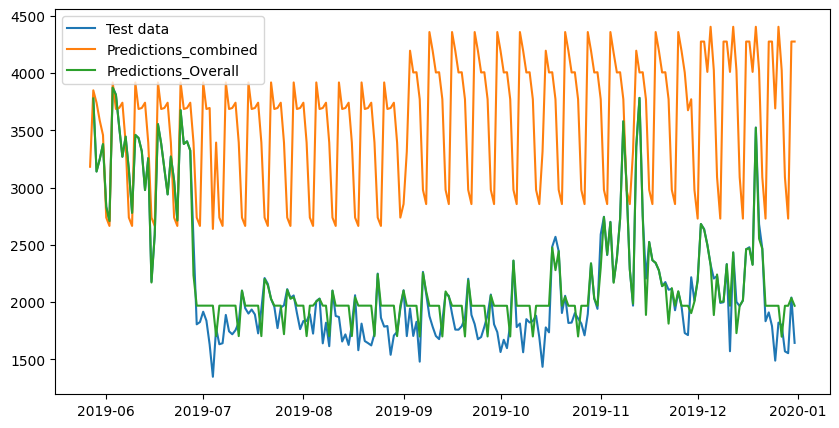

In [108]:
plt.plot(predictions_rf['test'].fillna(0),label='Test data')
plt.plot(test_combined_clusters['predictions'].fillna(0),label='Predictions_combined')
plt.plot(predictions_rf['test_pred'].fillna(0),label='Predictions_Overall')
plt.legend();